# Two-stage Matching and Ranking model on Retail Product Data

### Why 2 levels?
- Classical classification models (lightgbm) often perform better than recommender models (als, lightfm)
- There is a lot of data, a lot of predictions (# items * # users) -> lightgbm cannot cope with such a volume
- But recommender models do the trick!
- We select top-N (200) candidates using a simple model (als) -> re-rank them with a complex model (lightgbm) and select top-k (10).

## Candidate selection
- We generate top-k candidates
- The quality of candidates is measured through recall @ k
- recall @ k shows what proportion of the purchased goods we were able to identify (recommend) with our model

## Setup

In [ ]:
!pip install -q implicit

In [ ]:
!git clone https://github.com/RecoHut-Stanzas/S593234
%cd S593234

In [ ]:
import sys
sys.path.insert(0, './code')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix
from implicit import als
from lightgbm import LGBMClassifier

from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_parquet('./data/bronze/train.parquet.gzip')
item_features = pd.read_parquet('./data/bronze/products.parquet.gzip')
user_features = pd.read_parquet('./data/bronze/demographics.parquet.gzip')

In [ ]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

## Train-test split

In [ ]:
# Learning and validation scheme is important!
# - old purchases - | - 6 weeks - | - 3 weeks -
# select the size of the 2nd dataset (6 weeks) -> learning curve (dependence of the recall @ k metric on the size of the dataset)
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# take data for training matching model
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# take data to validate the matching model
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# take data for training ranking model
data_train_ranker = data_val_matcher.copy()  # For clarity. Next we will add changes and they will be different.

# take data for the test ranking, matching model
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [ ]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [ ]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [ ]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


## Pre-filter items

In [ ]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 2483 to 2483


## Pre-filter users

In [ ]:
# looking for common users
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (863063, 13) Users: 2495 Items: 2483
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


## Training candidate selection recommender

In [ ]:
recommender = MainRecommender(data_train_matcher)

In [ ]:
recommender.get_als_recommendations(2375, N=5)

[899624, 823990, 1106523, 1044078, 1046545]

In [ ]:
recommender.get_own_recommendations(2375, N=5)

[1085983, 907099, 1079023, 1005935, 847066]

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 823990, 894124, 934399]

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

[1069003, 899459, 894360, 856942, 1063739]

## Eval recall of matching
Measuring recall @ k. Quality is measured at data_val_matcher: next 6 weeks after the train

In [ ]:
ACTUAL_COL = 'actual'
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [ ]:
# N = Neighbors
N_PREDICT = 50 

result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [ ]:
def evalRecall(df_result, target_col_name, recommend_model):
    result_col_name = 'result'
    df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
    return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [ ]:
### Recall@50 of matching
TOPK_RECALL = 50
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)
[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04739425945698195),
 ('sim_item_rec', 0.03399733646258331)]

[('own_rec', 0.06525657038145175),
 ('als_rec', 0.04739425945698195),
 ('sim_item_rec', 0.03399733646258331)]

In [ ]:
### Precision@5 of matching
TOPK_PRECISION = 5
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.19414225941422392),
 ('als_rec', 0.10134821013482044),
 ('sim_item_rec', 0.06155276615527696)]

## Ranking

```
# Train the Level 2 Model on Selected Candidates
# We train on data_train_ranking
# We train only on selected candidates
# For example, I will generate the top 50 candidates via get_own_recommendations
# Note: If the user has bought <50 products, then get_own_recommendations will add top-popular recommendations
# 3 time slots
# - old purchases - | - 6 weeks - | - 3 weeks -
```

In [ ]:
# Preparing data for the train
# took users from the train for ranking
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [ ]:
# collecting candidates from the first stage (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1092937, 917033, 10198378, 1008814, 1016800, ..."
1,2021,"[1119454, 835578, 863762, 1013928, 1019142, 65..."


In [ ]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,2070,1092937
0,2070,917033
0,2070,10198378
0,2070,1008814


In [ ]:
# Check warm start
print_stats_data(df_match_candidates, 'match_candidates')

# We create a training set for ranking taking into account candidates from stage 1
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train ['target'] = 1 # there are only purchases
df_ranker_train.head ()

match_candidates
Shape: (107550, 2) Users: 2151 Items: 2225


,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [ ]:
# There are not enough zeros in the dataset, so we add our candidates to the quality of zeros
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# clean up duplicates
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace = True)
df_ranker_train.target.value_counts()

0.0    96997
1.0     9004
Name: target, dtype: int64

In [ ]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1092937,1.0
2,2070,917033,0.0


In [ ]:
df_ranker_train['target'].mean()

0.08494259488118036

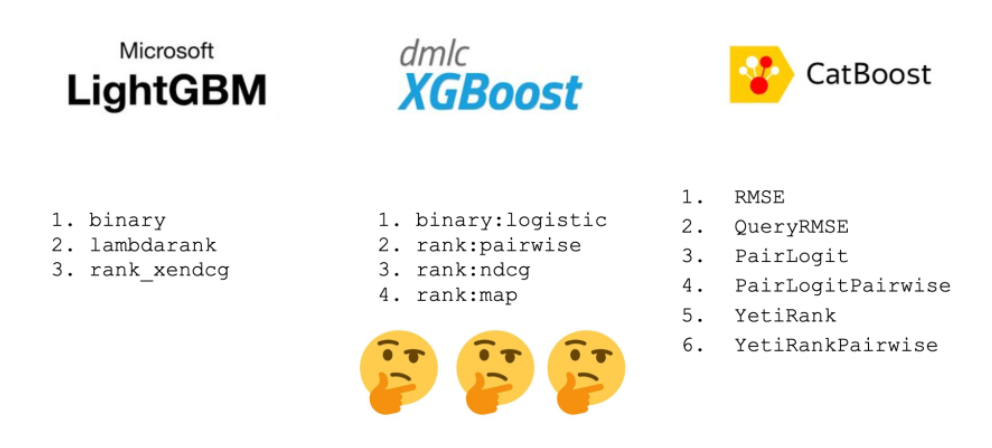

For now, for ease of training, we will choose LightGBM with loss = binary. This is a classic binary classification

This is an example without feature generation

Other good choices:
- classification via LightGBM
- CatBoost ranking via YetiRank, YetiRankPairwise

### Preparing features for training the model

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')
df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


Features user_id:

- Average check
- Average purchase amount for 1 product in each category
- Number of purchases in each category
- Frequency of purchases once / month
- Share of shopping on weekends
- Share of purchases in the morning / afternoon / evening

Features item_id:

- Number of purchases per week
- Average number of purchases of 1 product per category per week
- (Number of purchases per week) / (Average number of purchases of 1 item per category per week)
- Price (Can be calculated from retil_train.csv)
- Price / Average price of a product in a category

Features of the pair user_id - item_id

- (Average purchase amount for 1 product in each category (we take the item_id category)) - (Price item_id)
- (Number of purchases by a user of a specific category per week) - (Average number of purchases by all users of a specific category per week)
- (Number of purchases by a user of a specific category per week) / (Average number of purchases by all users of a specific category per week)

**Note on possible features in the 2nd level model**
- Collaborative:
    - biases + embeddings from collaborative filtration / score item2item models
    - TF-IDF mattress items with> N purchases
    - TF-IDF + TSNE / UMAP
- handcrafted product features:
    - product categories
    - standardized frequency of purchase of goods for each customer
    - number of stores in which the product was sold
    - number of client transactions
    - mean / max / std number of unique items in the customer's cart
    - mean / max / std number of unique categories in the customer's cart
- handcrafted features for users:
    - Average check
    - Average price of one purchased item
    - Average number of days between purchases / since last purchase
    - Number of unique purchases across all categories transaction_id, product_id, store_id, level_i_id
    - Signs with accumulated bonuses
    - Average discount, share of purchased goods with discounts
- Interesting:
    - The fact of ordering each product in the last 5 transactions as a sequence of bits (categorical feature). 10001 - bought the item in the last transaction and 5 transactions ago (feature hashing)
    - item co_ocurrence
    - word2vec product embeddings (alternative name - item2vec, prod2vec)
    - Distance from word2vec product embedding to average user-bought product embeddings

In [ ]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

### Training the ranking model

In [ ]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,proba_item_purchase
0,2070,1092937,1.0,1089,MEAT-PCKGD,National,LUNCHMEAT,BOLOGNA,16OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.283763
1,2070,917033,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.108728
2,2070,10198378,0.0,69,GROCERY,Private,DOG FOODS,DRY DOG VALUE (PET PRIDE/KLR/G,50 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.152175
3,2070,1008814,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.090768
4,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,0.090768


We trained the ranking model on purchases from the data_train_ranker set and on candidates from own_recommendations, which is a training set, and now our task is to predict and evaluate on the test set.

### Evaluation on test dataset

In [ ]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Eval matching on test dataset

measure precision only of the matching model to understand the impact of ranking on metrics

In [ ]:
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.1629411764705864)]

### Eval re-ranked matched result on test dataset

We take the top k predictions, ranked by probability, for each user

In [ ]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.16501305483028583)
('own_rec', 0.1629411764705864)


---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p implicit

Author: Sparsh A.

Last updated: 2021-12-05 13:59:10

implicit: 0.4.8

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

matplotlib: 3.2.2
IPython   : 5.5.0
numpy     : 1.19.5
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas    : 1.1.5



---

**END**